### Prepare maps for analysis

## NB: This is deprecated in favor of narps.py

#### Hypotheses:

Parametric effect of gain:

1. Positive effect in ventromedial PFC - for the equal indifference group
2. Positive effect in ventromedial PFC - for the equal range group
3. Positive effect in ventral striatum - for the equal indifference group
4. Positive effect in ventral striatum - for the equal range group

Parametric effect of loss:
- 5: Negative effect in VMPFC - for the equal indifference group
- 6: Negative effect in VMPFC - for the equal range group
- 7: Positive effect in amygdala - for the equal indifference group
- 8: Positive effect in amygdala - for the equal range group

Equal range vs. equal indifference:

- 9: Greater positive response to losses in amygdala for equal range condition vs. equal indifference condition.

#### Notes on data

Data and hypothesis decisions were obtained from 70 teams.  Of these, the maps for 13 teams were excluded from further analysis due to the following problems:

##### Bad normalization/resampling:

- SVXXBBHN_98BT: rejected due to very bad normalization
- UGXECSGG_L1A8: resampled image much smaller than template brain
- VDOVGCPL_4SZ2: resampled image offset from template brain
- WBTVHMSS_4TQ6: resampled image  offset and too large compared to template


##### Missing thresholded images:

- WIYTWEEA_2T7P: missing thresholded images


##### Used surface-based analysis (only provided data for cortical ribbon:

- DRVQPPNO_1K0E
- UMSEIVRB_X1Z4 


##### Bad unthresholded images:

- TMZGNUWI_R5K7: "unthresholded" images appeared to be thresholded



##### Missing data:

- YWGVKXBZ_6FH5: missing much of the central brain
- ACMKXFTG_P5F3: rejected due to large amounts of missing data across brain
- NNUNPWLT_0H5E: rejected due to large amount of missing brain in center
- CMJIFMMR_L3V8: rejected due to large amount of missing brain in center


##### Bad histograms:  
visual examiniation of histograms of unthresholded images showed a number of them that were clearly not distribted as z/t

- RIIVGRDK_E3B6: very long tail, with substantial inflation at a value just below zero
- JAWCZRDS_V55J: very small values
- EPBGXICO_I07H: bimodal, with second distribution centered around 2.5
- UXJVRRRR_0C7Q: appears to be a p-value distribution, with slight excursions below and above zero
- OXLAIRNK_Q58J: bimodal, zero-inflated with a second distribution centered around 5




In [1]:
import numpy,pandas
import nibabel
import json
import os,glob
import nilearn.image
import nilearn.input_data
import nilearn.plotting
from collections import OrderedDict
import shutil
import warnings
import sklearn
import matplotlib.pyplot as plt
import seaborn
import pickle
from utils import get_masked_data,get_metadata,get_teamID_to_collectionID_dict,TtoZ

from narps import Narps


from nipype.interfaces.fsl.model import SmoothEstimate



/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# set up directories
basedir='/Users/poldrack/data_unsynced/NARPS'
narps = Narps(basedir)
narps.get_binarized_thresh_masks()
narps.get_resampled_images()
image_value_df = narps.check_image_values()


found 53 input directories
found 53 teams with complete original datasets
getting binarized/thresholded orig maps
getting resampled images...
checking image values...


### Processing the statistical images

In [7]:
print('checking for na voxels')
found_na=False
for i in input_dirs:
    collectionID = os.path.basename(i)
    for hyp in range(1,10):
        if n_nan[collectionID][hyp]>0:
            print('Found nans:',collectionID,hyp)
            found_na=True
if not found_na:
    print('no NAs found!')
print('')

print("teams with in-mask zeros per image")
for i in input_dirs:
    collectionID = os.path.basename(i)
    for hyp in range(1,10):
        if n_zero[collectionID][hyp]>0:
            print(collectionID,n_zero[collectionID])
            break



checking for na voxels
no NAs found!

teams with in-mask zeros per image
CLTGPQPO_43FJ {1: 13280, 2: 15203, 3: 13280, 4: 15203, 5: 13280, 6: 15203, 7: 13280, 8: 15203, 9: 17832}
MQKTVNIH_08MQ {1: 9, 2: 7, 3: 9, 4: 7, 5: 9, 6: 7, 7: 9, 8: 7, 9: 7}
YGVUUZDV_IZ20 {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 30, 7: 0, 8: 0, 9: 0}
NPZYAJUF_94GU {1: 30362, 2: 31321, 3: 30362, 4: 31321, 5: 30362, 6: 31321, 7: 30362, 8: 31321, 9: 35599}
CMGDLXNE_C22U {1: 8331, 2: 8331, 3: 8331, 4: 8331, 5: 8331, 6: 8331, 7: 8331, 8: 8331, 9: 8331}
ZNLBVOZG_UK24 {1: 30, 2: 30, 3: 30, 4: 30, 5: 30, 6: 30, 7: 30, 8: 30, 9: 30}
PJLEEUYF_46CD {1: 30182, 2: 32314, 3: 30182, 4: 32314, 5: 30560, 6: 32284, 7: 30560, 8: 32284, 9: 38912}
LASLHJJB_I52Y {1: 106, 2: 65, 3: 106, 4: 65, 5: 106, 6: 65, 7: 106, 8: 65, 9: 49}
UOELUJTL_1P0Y {1: 41167, 2: 37306, 3: 41167, 4: 37306, 5: 41167, 6: 37306, 7: 41167, 8: 37306, 9: 44074}
MNWEYQKT_9U7M {1: 1022, 2: 1022, 3: 1022, 4: 1022, 5: 1022, 6: 1022, 7: 1022, 8: 1022, 9: 1022}
ZFFBNRMO_51PW {1

In [8]:
# rerun on all of the images rejected earlier due to bad resampling

rejected_teams = ['VDOVGCPL_4SZ2','WBTVHMSS_4TQ6','UGXECSGG_L1A8']
rejected_dirs = [os.path.join(orig_dir,'rejected/%s'%i) for i in rejected_teams]

mask_dir=os.path.join(output_dir,'thresh_mask_orig')
template_img = os.path.join(output_dir,'templates/MNI152_T1_2mm.nii.gz')

for r in rejected_dirs:
    print(resample_to_mni(r,mask_dir,template_img))

VDOVGCPL_4SZ2 :converting to FSL MNI space
VDOVGCPL_4SZ2
WBTVHMSS_4TQ6 :converting to FSL MNI space
WBTVHMSS_4TQ6
UGXECSGG_L1A8 :converting to FSL MNI space
UGXECSGG_L1A8


#### Combine thresholded images and create summary map

In [9]:
# save concatenated thresholded images to thresh_concat directory
overwrite = True
for hyp in range(1,10):
    outfile = os.path.join(output_dir,'thresh_concat/hypo%d.nii.gz'%hyp)
    hmaps = glob.glob(os.path.join(output_dir,'resampled/*/hypo%d_thresh.nii.gz'%hyp))
    hmaps.sort()
    labels = [os.path.basename(os.path.dirname(i)) for i in hmaps]
    
    if not os.path.exists(outfile) or overwrite:
        print('hypo %d: found %d maps'%(hyp,len(hmaps)))
        masker = nilearn.input_data.NiftiMasker(mask_img=full_mask_img)
        concat_data = masker.fit_transform(hmaps)
        concat_img = masker.inverse_transform(concat_data)
        concat_img.to_filename(outfile)
        with open(os.path.join(output_dir,'thresh_concat/labels_hypo%d.txt'%hyp),'w') as f:
            for l in labels:
                f.write('%s\n'%l)
    else:
        print('hypo %d: using existing file'%hyp)


hypo 1: found 52 maps
hypo 2: found 52 maps
hypo 3: found 52 maps
hypo 4: found 52 maps
hypo 5: found 52 maps
hypo 6: found 52 maps
hypo 7: found 52 maps
hypo 8: found 52 maps
hypo 9: found 52 maps


In [10]:
# create overlap maps for thresholded maps

for hyp in range(1,10):
    outfile = os.path.join(output_dir,'thresh_mean/hypo%d.nii.gz'%hyp)
    if not os.path.exists(outfile) or overwrite:
        print('hypo %d: found %d maps'%(hyp,len(hmaps)))
        concat_img=nibabel.load(os.path.join(output_dir,'thresh_concat/hypo%d.nii.gz'%hyp))
        concat_data = concat_img.get_data()
        concat_data = (concat_data>10e-6).astype('float')
        concat_mean = numpy.mean(concat_data,3)
        concat_mean_img = nibabel.Nifti1Image(concat_mean,affine=concat_img.header.get_best_affine())
        concat_mean_img.to_filename(outfile)
    else:
        print('hypo %d: using existing file'%hyp)


hypo 1: found 52 maps
hypo 2: found 52 maps
hypo 3: found 52 maps
hypo 4: found 52 maps
hypo 5: found 52 maps
hypo 6: found 52 maps
hypo 7: found 52 maps
hypo 8: found 52 maps
hypo 9: found 52 maps


#### Convert all unthresholded images to Z stat images

#### Rectify maps

rectify the unthresholded maps if they used positive values for negative activations.  We check this automatically by comparing the thresholded and unthresholded maps - if all voxels within the thresholded map are negative, then we multiply the unthresholded map by -1


In [11]:
# make reports for in-mask voxel intensities

if os.path.exists(os.path.join(output_dir,'mask_vals.pkl')) and os.path.exists(os.path.join(output_dir,'maskdata_df.pkl')):
    print('using pickled data')
    with open(os.path.join(output_dir,'mask_vals.pkl'),'rb') as f:
        mask_vals=pickle.load(f)
    with open(os.path.join(output_dir,'maskdata_df.pkl'),'rb') as f:
        maskdata_df=pickle.load(f)
else:
    maskdata = {}
    maskdata_df = {}
    mask_vals = {}

    for hyp in range(1,10):
        maskdata[hyp] = {}
        mask_vals[hyp]={}
        hmaps = glob.glob(os.path.join(output_dir,'orig/*/hypo%d_unthresh.nii.gz'%hyp))
        hmaps.sort()
        
        for utmap in hmaps:
            collection_id = os.path.basename(os.path.dirname(utmap))
            mask_vals[hyp][collection_id]={}
            # load thresholded image mask
            threshmask = utmap.replace('orig','thresh_mask_orig').replace('_unthresh','')
            threshmap = utmap.replace('_unthresh','_thresh')

            try:
                masker = nilearn.input_data.NiftiMasker(threshmask)
                threshdata = masker.fit_transform(threshmap)
                mask_vals[hyp][collection_id]['thresh']=threshdata
                unthreshdata = masker.fit_transform(utmap)
                mask_vals[hyp][collection_id]['unthresh']=unthreshdata
                data_match = numpy.allclose(threshdata,unthreshdata)
                positive = numpy.min(unthreshdata)>=0
                negative = numpy.max(unthreshdata)<=0
                nvox = threshdata.shape[1]
                maskdata[hyp][collection_id] = [data_match,positive,negative,nvox,
                                                numpy.min(threshdata),numpy.max(threshdata),
                                                numpy.min(unthreshdata),numpy.max(unthreshdata)]
            except:
                maskdata[hyp][collection_id] = [numpy.nan,numpy.nan,numpy.nan,0,
                                                numpy.nan,numpy.nan,
                                                numpy.nan,numpy.nan]


        maskdata_df[hyp]=pandas.DataFrame(maskdata[hyp],index=['datamatch','all_positive','all_negative','nvox',
                                                            'thresh_min','thresh_max','unthresh_min','unthresh_max']).T

    with open(os.path.join(output_dir,'mask_vals.pkl'),'wb') as f:
        pickle.dump(mask_vals,f)
    with open(os.path.join(output_dir,'maskdata_df.pkl'),'wb') as f:
        pickle.dump(maskdata_df,f)


using pickled data


In [12]:
# get report of datasets for each hypothesis that are not either all positive or all negative
bad_subs={}
for hyp in range(1,10):
    bad = maskdata_df[hyp].query('datamatch==False').index.tolist()
    for b in bad:
        if not b in bad_subs:
            bad_subs[b]=[]
        bad_subs[b].append(hyp)
print(bad_subs)

{'BEWWYWBV_5G9K': [1, 3, 6], 'CGGOUIDK_X1Y5': [1, 2, 3, 4, 5, 6, 7, 8], 'HDZTOPFX_XU70': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'JGNYNCRJ_80GC': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'LSGXYMCM_27SS': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'MQKTVNIH_08MQ': [1, 3, 5, 7, 9], 'WLJQPTCD_O6R6': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'YGVUUZDV_IZ20': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'ZFFBNRMO_51PW': [1, 2, 3, 4, 5, 6, 7, 9], 'RWUMYGCX_6VV2': [2, 4, 5, 6, 7, 8, 9], 'PJLEEUYF_46CD': [5, 6], 'WYHPMBFA_2T6S': [5, 7], 'NAOARURV_DC61': [6], 'PPCCKOJA_0JO0': [6]}


In [13]:
# find datasets that contain all neg voxels within mask - these will be rectified

all_neg={}
for hyp in range(1,10):
    bad = maskdata_df[hyp].query('all_negative==True').index.tolist()
    for b in bad:
        if not b in all_neg:
            all_neg[b]=[]
        all_neg[b].append(hyp)
print(all_neg)

{'IYQMMKMM_UI76': [5, 6], 'JGNYNCRJ_80GC': [5, 6, 9], 'MNWEYQKT_9U7M': [5], 'NUJQNDED_L9G5': [5, 6], 'PJLEEUYF_46CD': [5, 6], 'RWUMYGCX_6VV2': [5, 6], 'UGXZBNJS_AO86': [5, 6, 7, 8], 'WYHPMBFA_2T6S': [5, 7], 'PPCCKOJA_0JO0': [6], 'CQCJIRXE_O03M': [9]}


In [14]:
# rectify images

input_dirs = glob.glob(os.path.join(output_dir,'resampled/*'))

rectified = []

for i in input_dirs:
    # make sure there are images
    images = glob.glob(os.path.join(i,'*.nii.gz'))
    if len(images)==0:
        continue
    
    outdir = i.replace('resampled','rectified')
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    collection_id = os.path.basename(i)
        
    for hyp in range(1,10):
        if collection_id in all_neg:
            if hyp in all_neg[collection_id]:
                rectify=True
            else:
                rectify=False
        # rectify or copy unthresh image
        imgfile = os.path.join(i,'hypo%d_unthresh.nii.gz'%hyp)
        outfile = os.path.join(outdir,'hypo%d_unthresh.nii.gz'%hyp)
        if not os.path.exists(outfile):
            if rectify:
                    print('rectifying',collection_id,hyp)
                    img = nibabel.load(imgfile)
                    img_rectified = nilearn.image.math_img('img*-1',img=img)
                    img_rectified.to_filename(outfile)
                    continue
            else:
                shutil.copy(imgfile,outfile)
        
        # also copy thresh file to rectified directory
        imgfile = os.path.join(i,'hypo%d_thresh.nii.gz'%hyp)
        outfile = os.path.join(outdir,'hypo%d_thresh.nii.gz'%hyp)
        if not os.path.exists(outfile):
            shutil.copy(imgfile,outfile)


In [15]:
# compute stats on rectified images
unthresh_hmaps={}
for hyp in range(1,10):
    hmaps = glob.glob(os.path.join(output_dir,'rectified/*/hypo%d_unthresh.nii.gz'%hyp))
    hmaps.sort()
    unthresh_hmaps[hyp]=hmaps
    print('hypo %d: found %d maps'%(hyp,len(hmaps)))
    concat_outfile=os.path.join(output_dir,'unthresh_concat/hypo%d.nii.gz'%hyp)
    labels = [os.path.basename(os.path.dirname(i)) for i in hmaps]

    if not os.path.exists(concat_outfile):
        masker = nilearn.input_data.NiftiMasker(mask_img=full_mask_img)
        concat_data = masker.fit_transform(hmaps)
        concat_img = masker.inverse_transform(concat_data)
        concat_img.to_filename(concat_outfile)
        with open(os.path.join(output_dir,'unthresh_concat/labels_hypo%d.txt'%hyp),'w') as f:
            for l in labels:
                f.write('%s\n'%l)

        
    # compute range
    range_outfile=os.path.join(output_dir,'unthresh_range/hypo%d.nii.gz'%hyp)
    var_outfile=os.path.join(output_dir,'unthresh_std/hypo%d.nii.gz'%hyp)
    if not os.path.exists(range_outfile) or not os.path.exists(var_outfile):
        concat_data=numpy.nan_to_num(concat_img.get_data())
        datarange = numpy.max(concat_data,axis=3) - numpy.min(concat_data,axis=3)
        range_img = nibabel.Nifti1Image(datarange,affine=concat_img.header.get_best_affine())
        range_img.to_filename(range_outfile)
        datavar = numpy.std(concat_data,axis=3)
        var_img = nibabel.Nifti1Image(datavar,affine=concat_img.header.get_best_affine())
        var_img.to_filename(var_outfile)
    


hypo 1: found 52 maps
hypo 2: found 52 maps
hypo 3: found 52 maps
hypo 4: found 52 maps
hypo 5: found 52 maps
hypo 6: found 52 maps
hypo 7: found 52 maps
hypo 8: found 52 maps
hypo 9: found 52 maps


In [16]:
# 
thresh_summary = []
for hyp in range(1,10):
    thresh_summary.append([numpy.mean(maskdata_df[hyp].datamatch),
          numpy.mean(maskdata_df[hyp].all_positive),
          numpy.mean(maskdata_df[hyp].all_negative)])
thresh_summary_df = pandas.DataFrame(thresh_summary,columns=['p_datamatch','p_allpositive','p_allnegative'])
thresh_summary_df['all_consistent'] = thresh_summary_df.p_allpositive + thresh_summary_df.p_allnegative
thresh_summary_df

,p_datamatch,p_allpositive,p_allnegative,all_consistent
0,0.808511,0.702128,0.000000,0.702128
1,0.836735,0.816327,0.000000,0.816327
2,0.808511,0.702128,0.000000,0.702128
3,0.833333,0.812500,0.000000,0.812500
4,0.780000,0.640000,0.160000,0.800000
5,0.733333,0.666667,0.155556,0.822222
6,0.791667,0.750000,0.041667,0.791667
7,0.825000,0.800000,0.025000,0.825000
8,0.764706,0.823529,0.058824,0.882353


In [19]:
# make report for thresh/unthresh maps
cut_coords = [-24,-10,4,18,32,52,64]

hyp=1
ctr=0
bins = numpy.linspace(-5,5)


for hyp in [1,2,5,6,7,8,9]:
    outfile = os.path.join(output_dir,'figures/hyp%d_mask_overlays.pdf'%hyp)
    if not os.path.exists(outfile):
        print('making figure for hyp',hyp)
        fig, ax = plt.subplots(len(mask_vals[hyp]),2,figsize=(len(mask_vals[hyp]),150),gridspec_kw={'width_ratios': [2, 1]})
        ctr=0
        for collection_id in mask_vals[hyp]:

            unthresh_img=os.path.join(output_dir,'orig/%s/hypo%d_unthresh.nii.gz'%(collection_id,hyp))
            thresh_img=os.path.join(output_dir,'thresh_mask_orig/%s/hypo%d.nii.gz'%(collection_id,hyp))
            if not (os.path.exists(thresh_img) or os.path.exists(unthresh_img)):
                continue
            display = nilearn.plotting.plot_stat_map(unthresh_img, display_mode="z", 
                    colorbar=True,title=collection_id,
                                      cut_coords = cut_coords,axes = ax[ctr,0],cmap='gray')

            with warnings.catch_warnings():  # ignore levels warning
                warnings.simplefilter("ignore")
                display.add_contours(thresh_img, filled=False, alpha=0.7, levels=[0.5], colors='b') 

            if 'unthresh' in mask_vals[hyp][collection_id]: # check for empty mask
                hist_result=ax[ctr,1].hist(mask_vals[hyp][collection_id]['unthresh'].flatten(),bins=bins)
            ctr+=1
        plt.savefig(outfile)
        plt.close(fig)


making figure for hyp 1
making figure for hyp 2
making figure for hyp 5
making figure for hyp 6
making figure for hyp 7
making figure for hyp 8
making figure for hyp 9


making figure for hyp 1
making figure for hyp 2
making figure for hyp 5
making figure for hyp 6
making figure for hyp 7
making figure for hyp 8
making figure for hyp 9


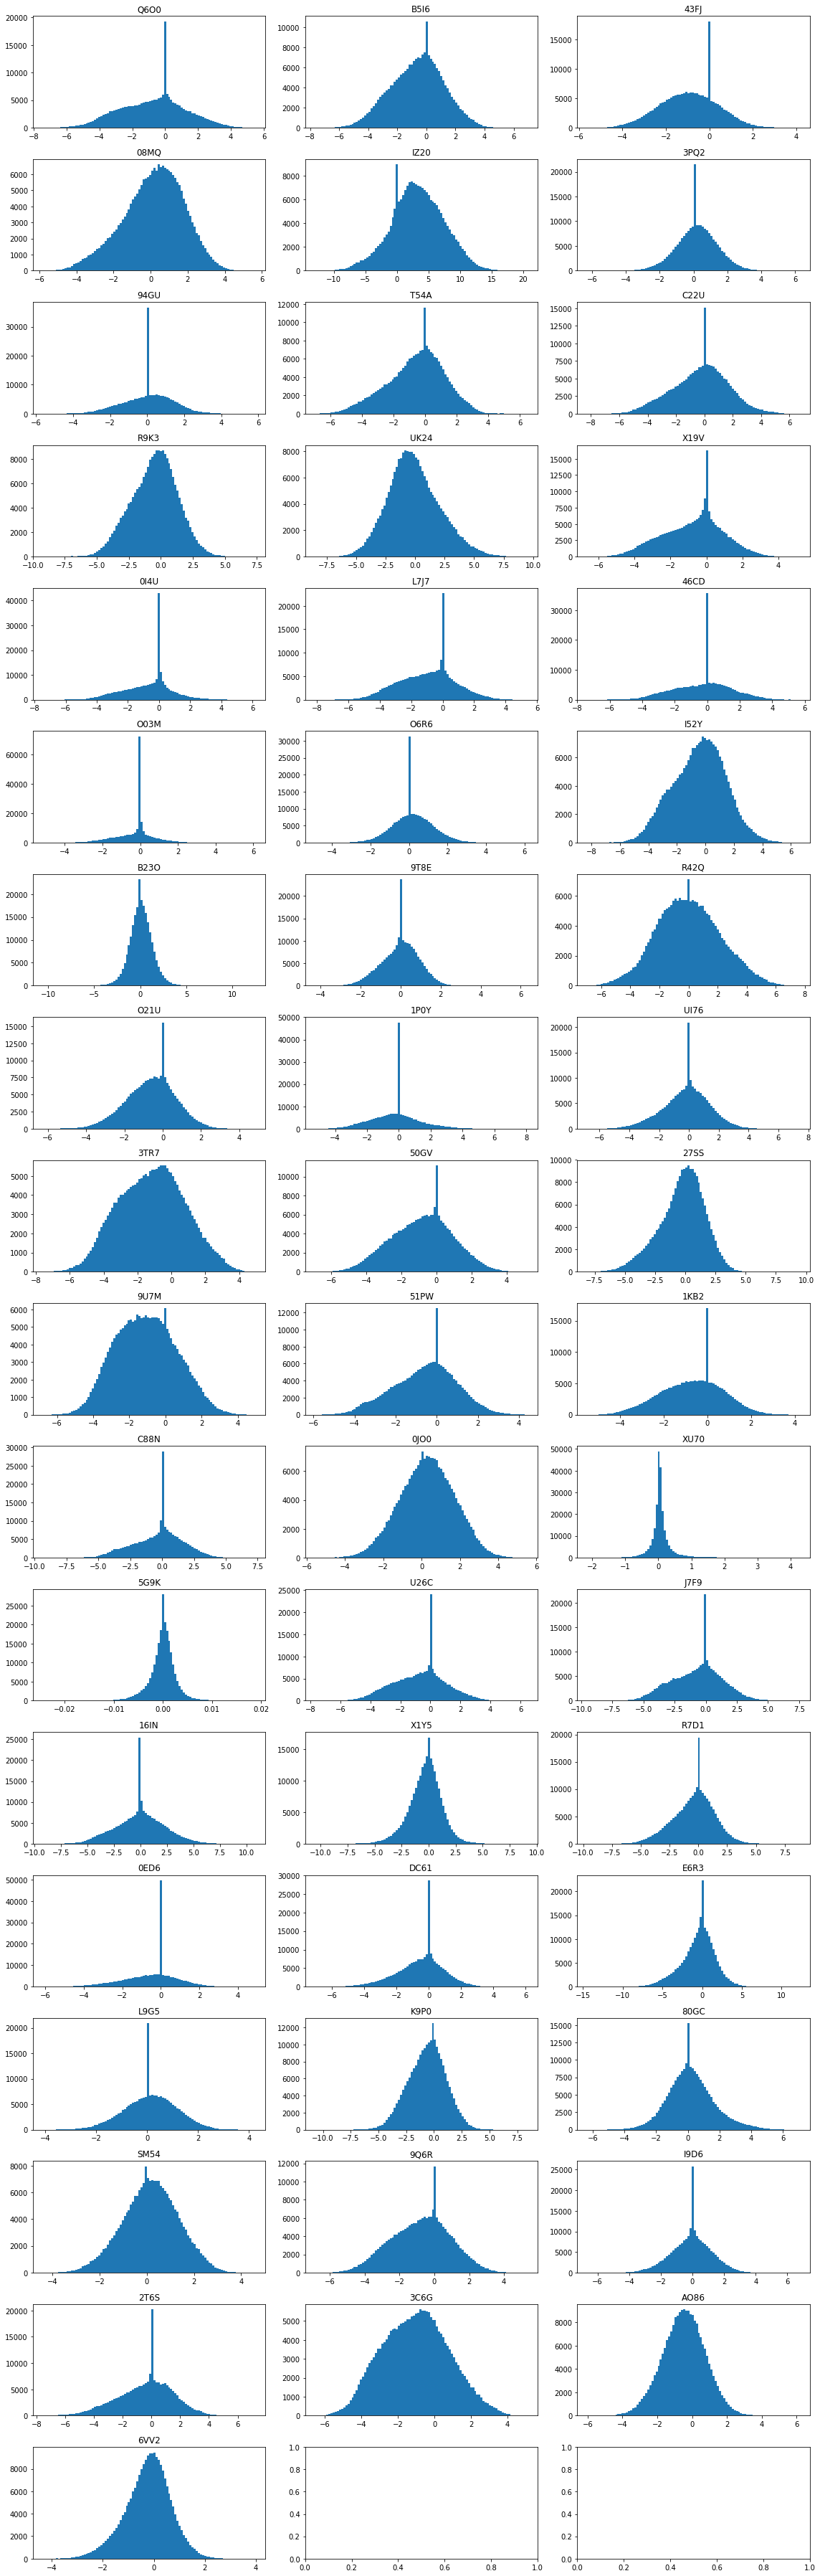

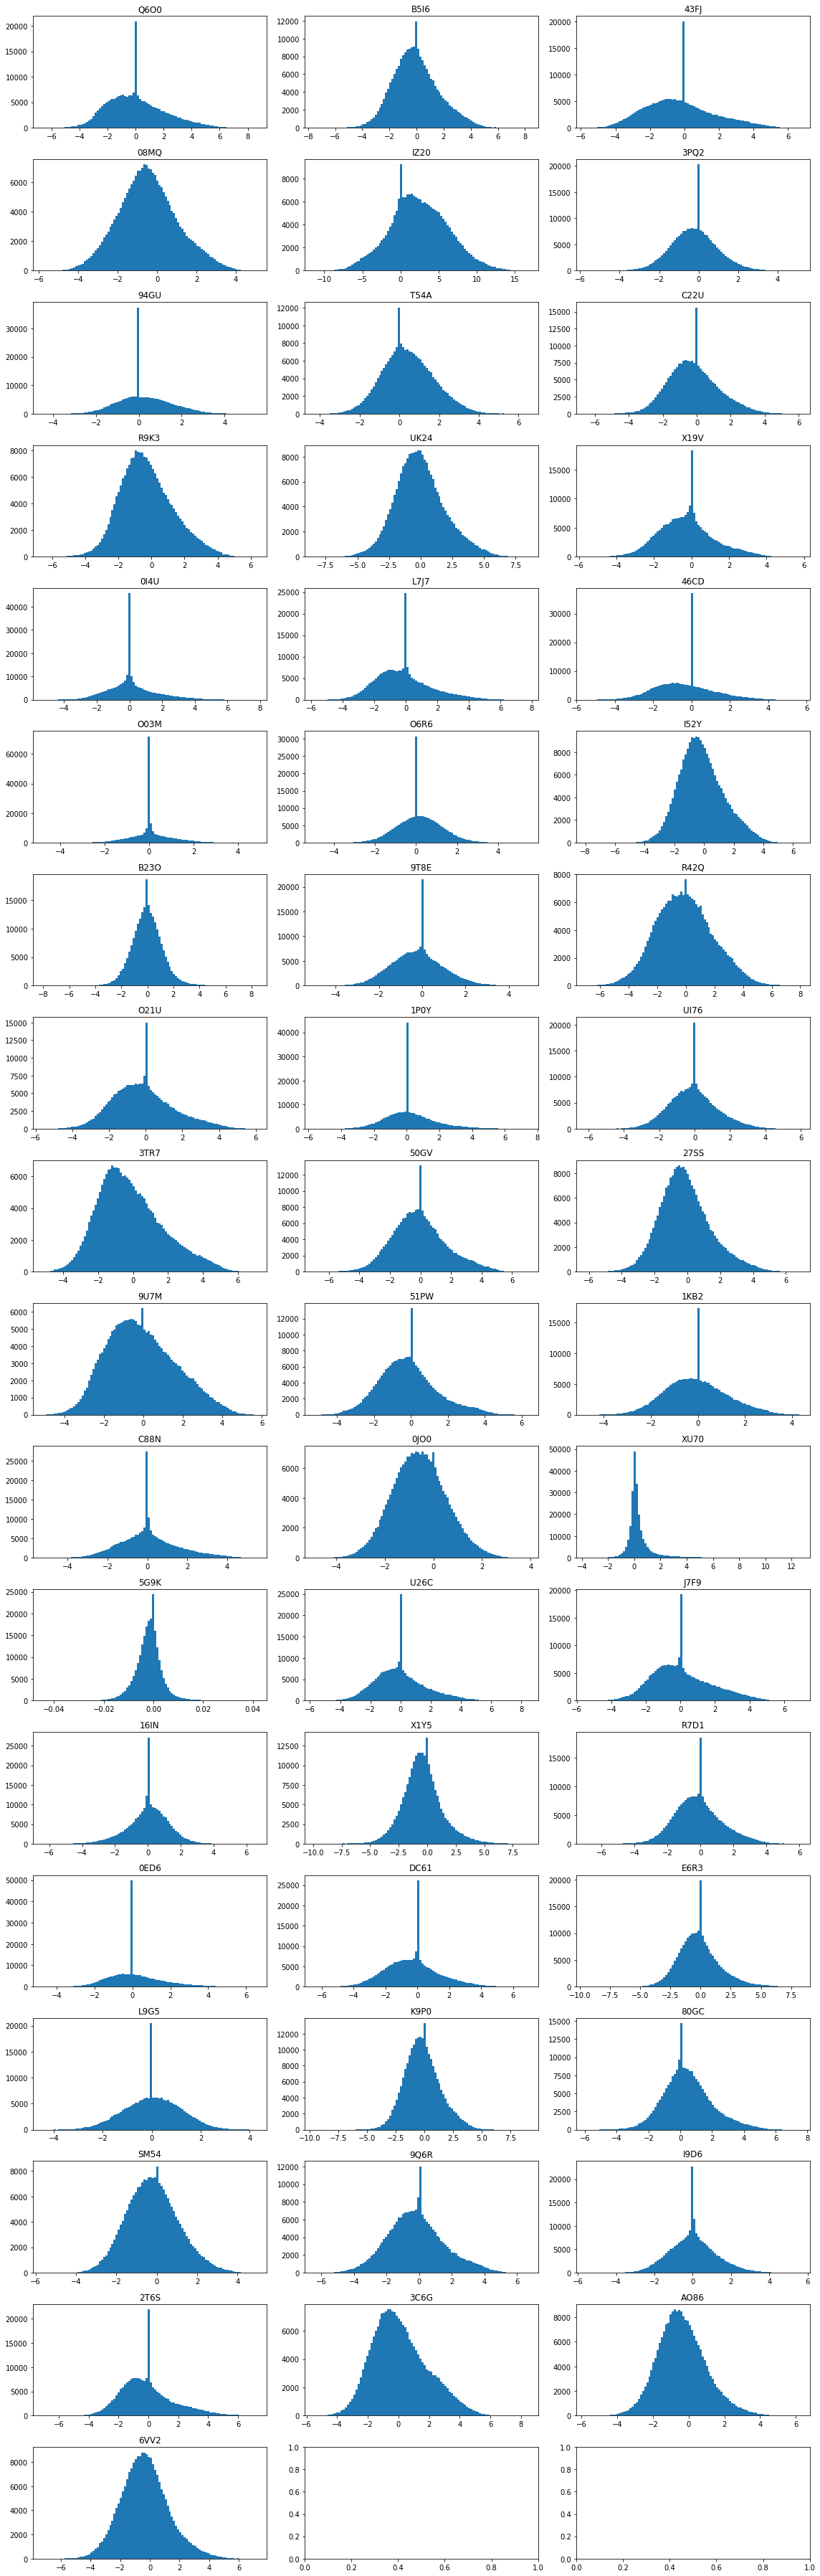

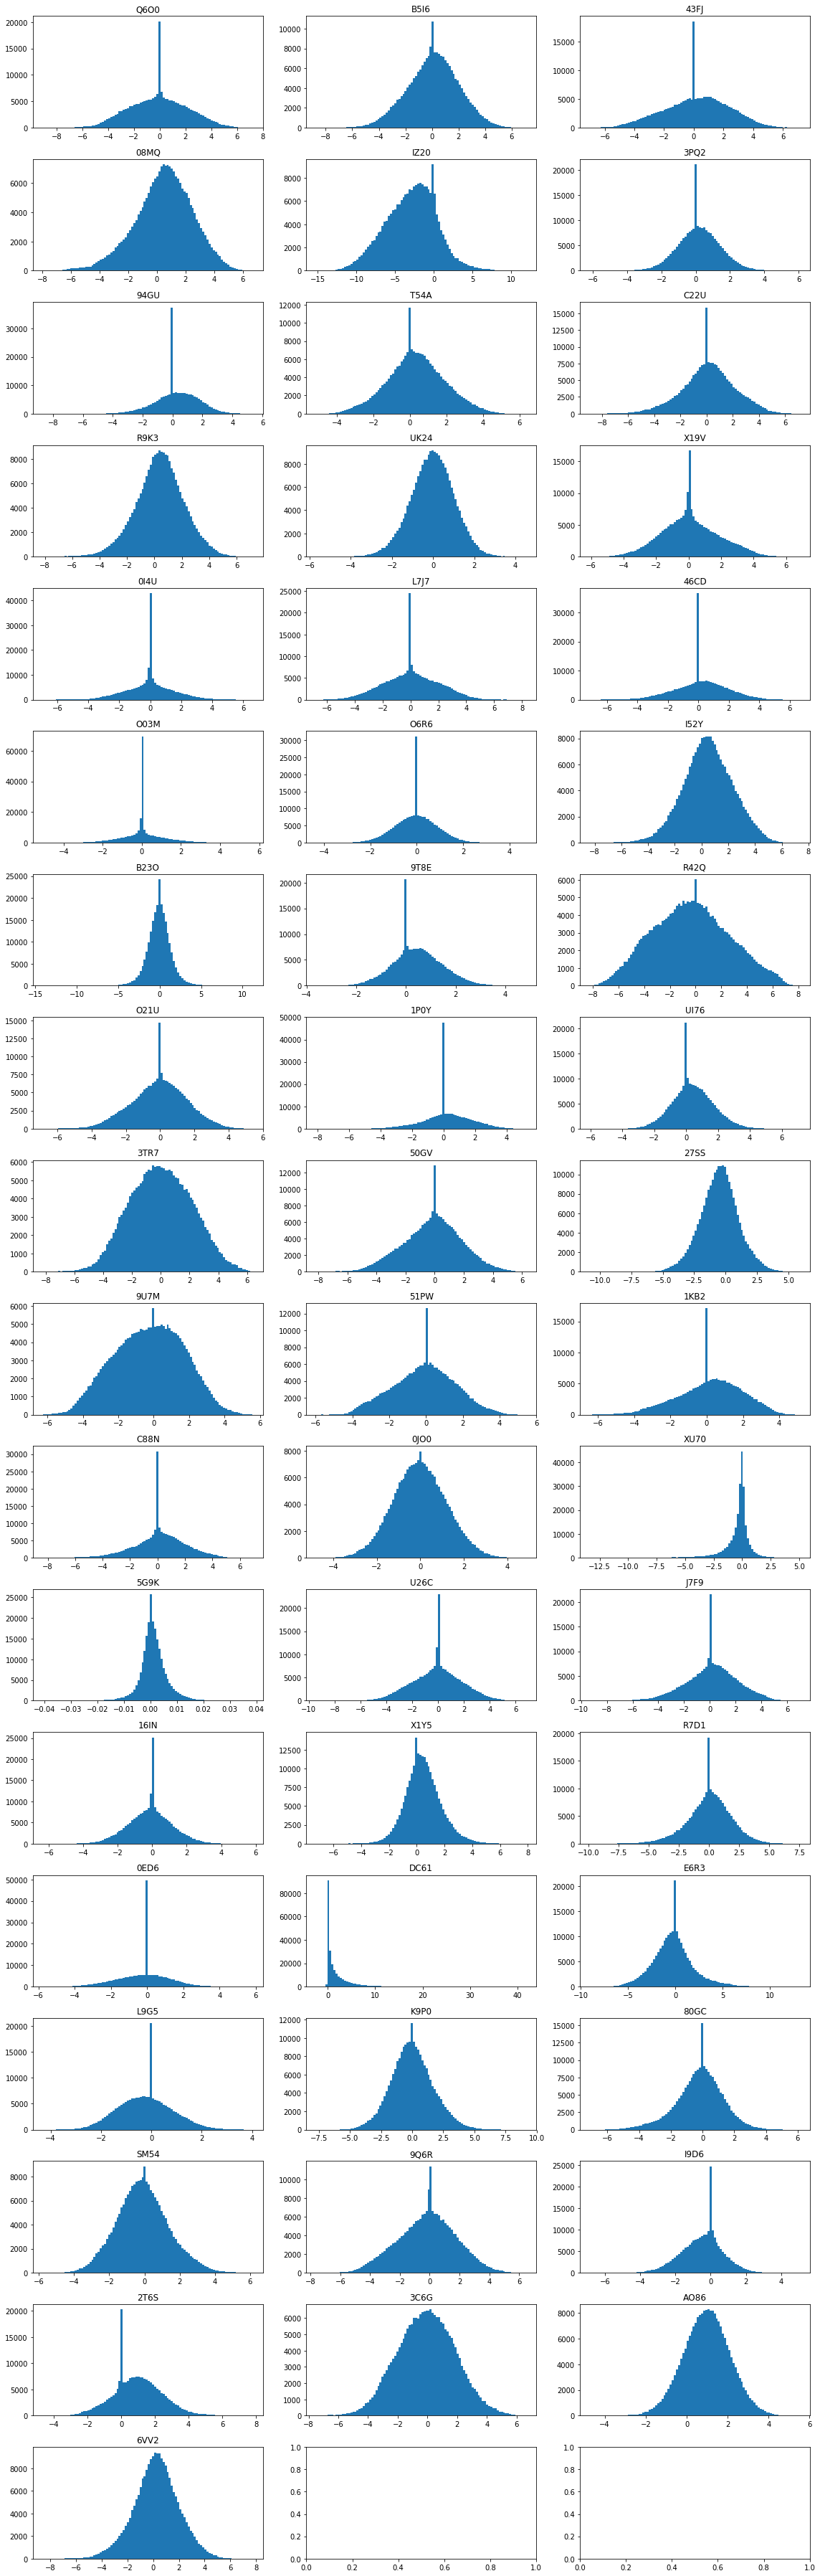

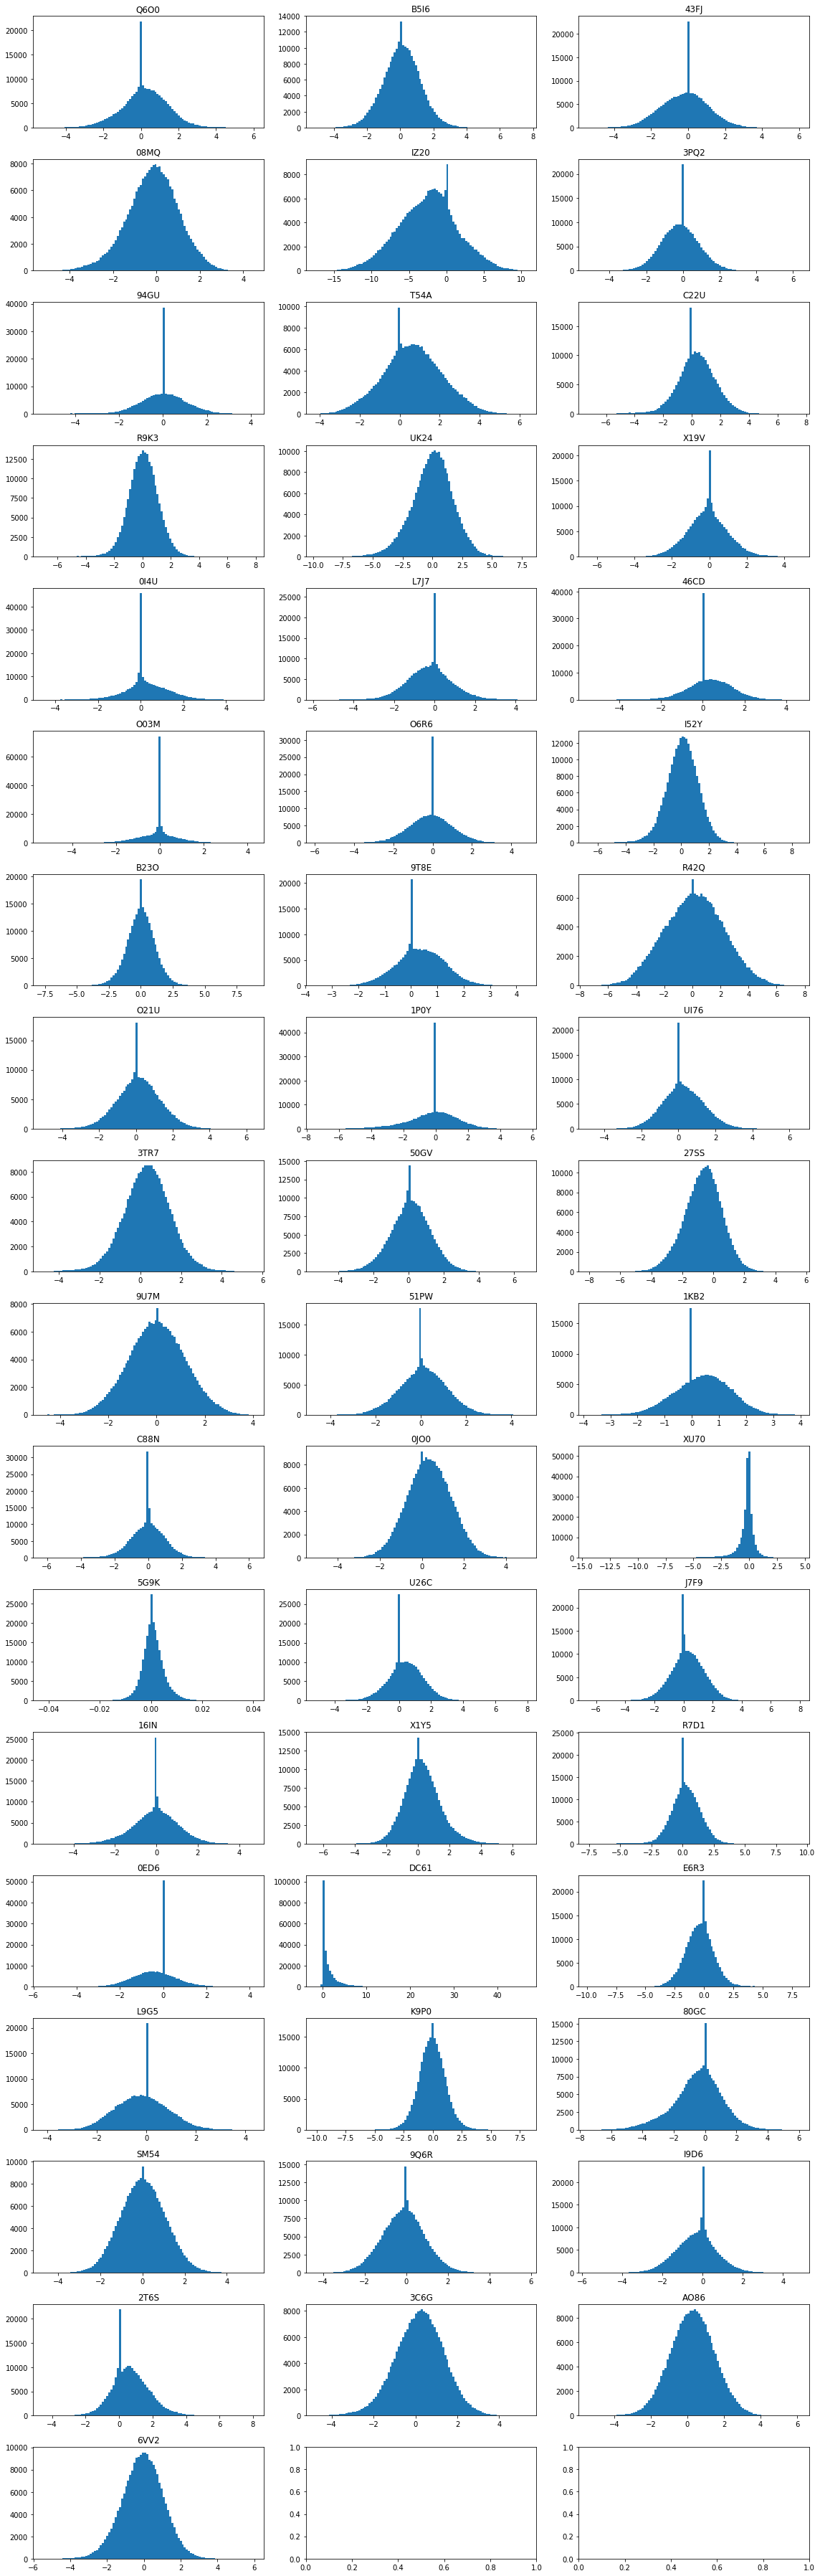

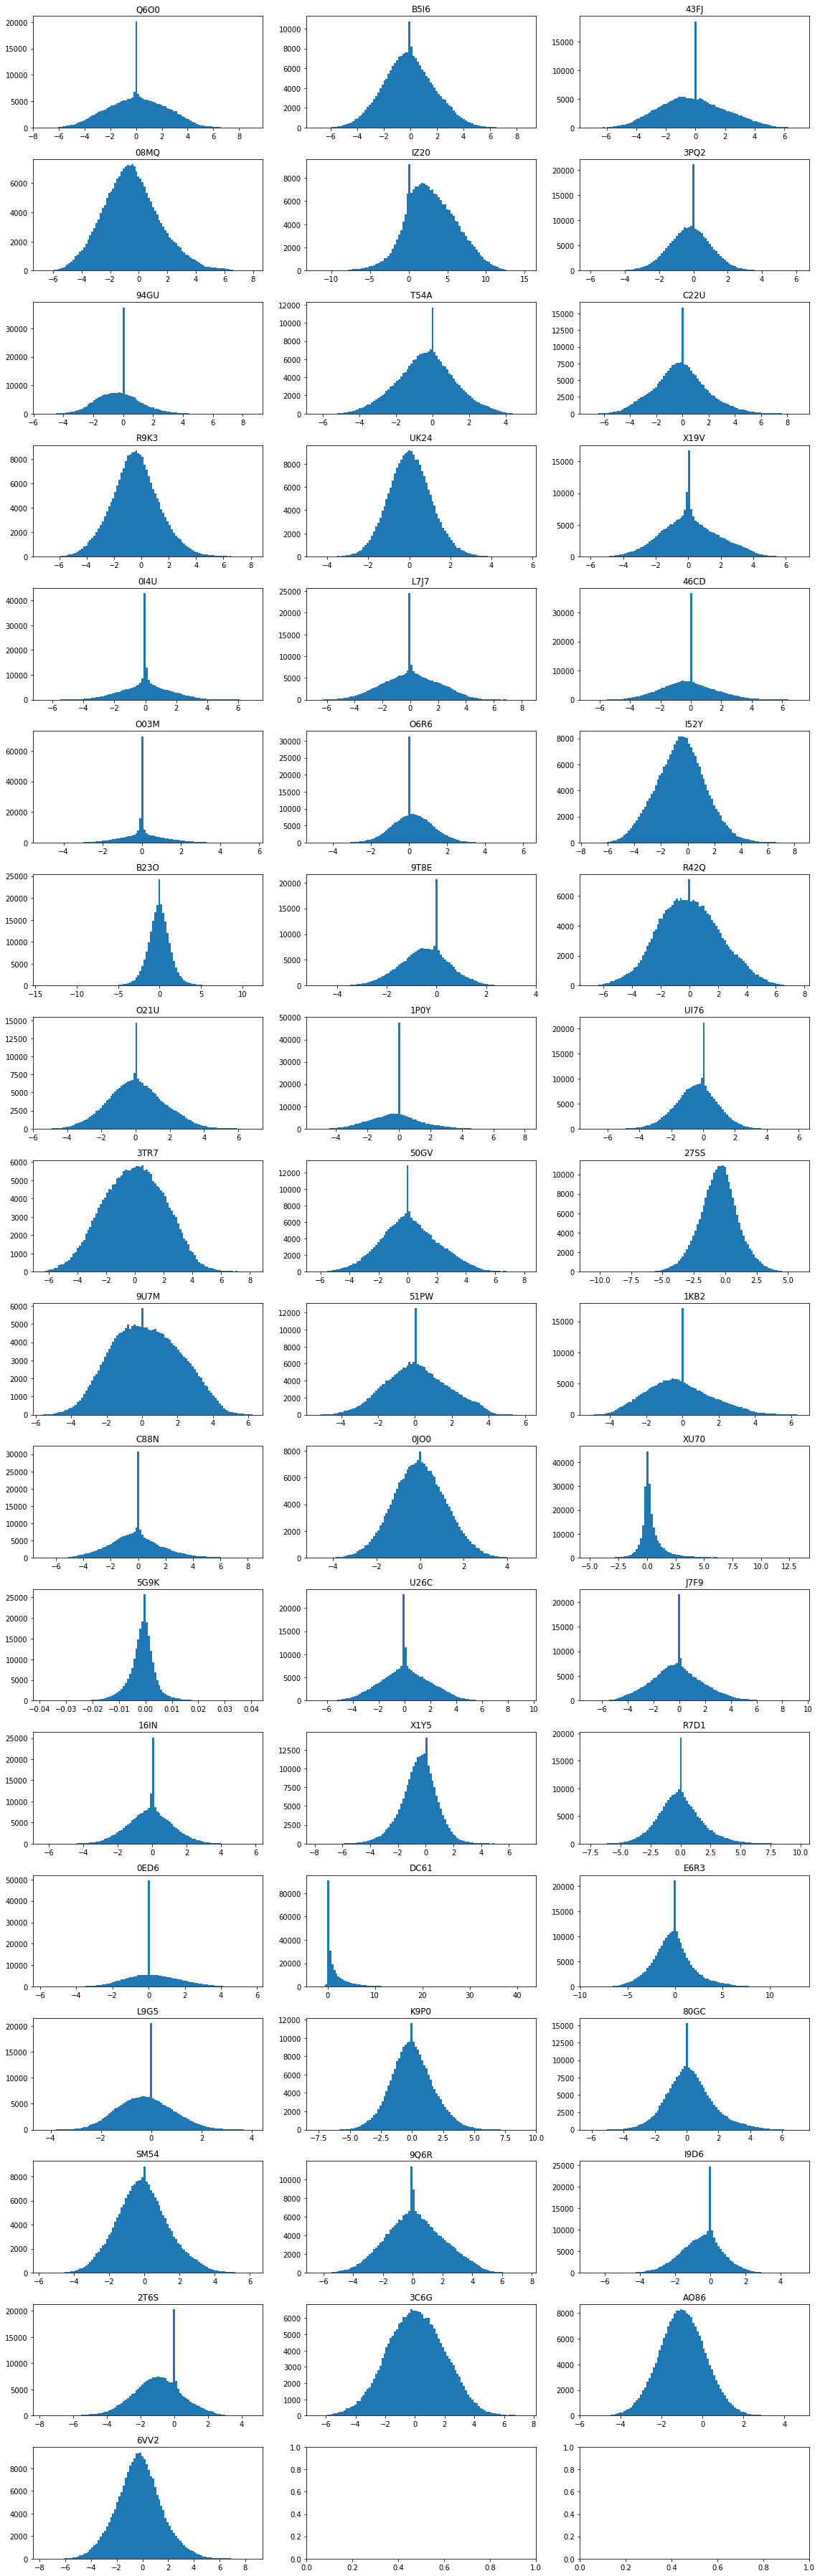

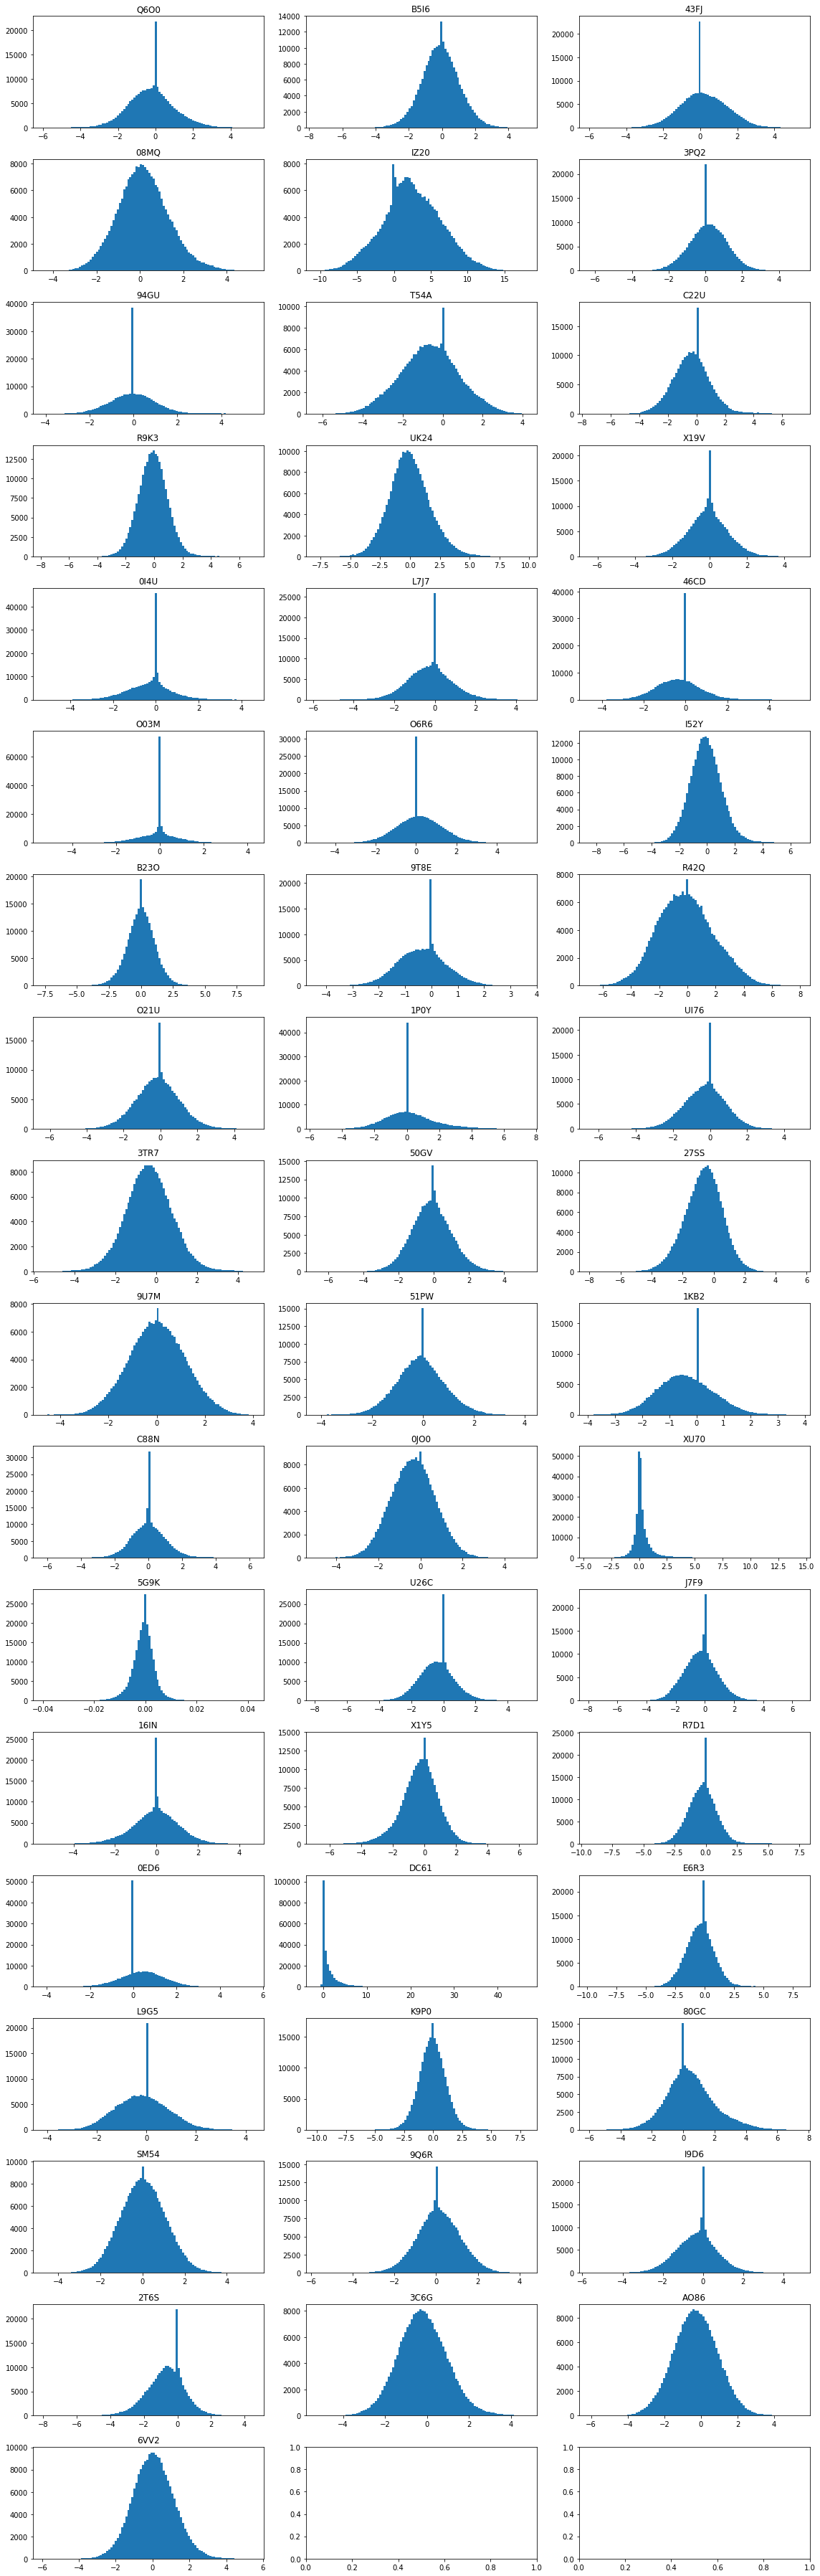

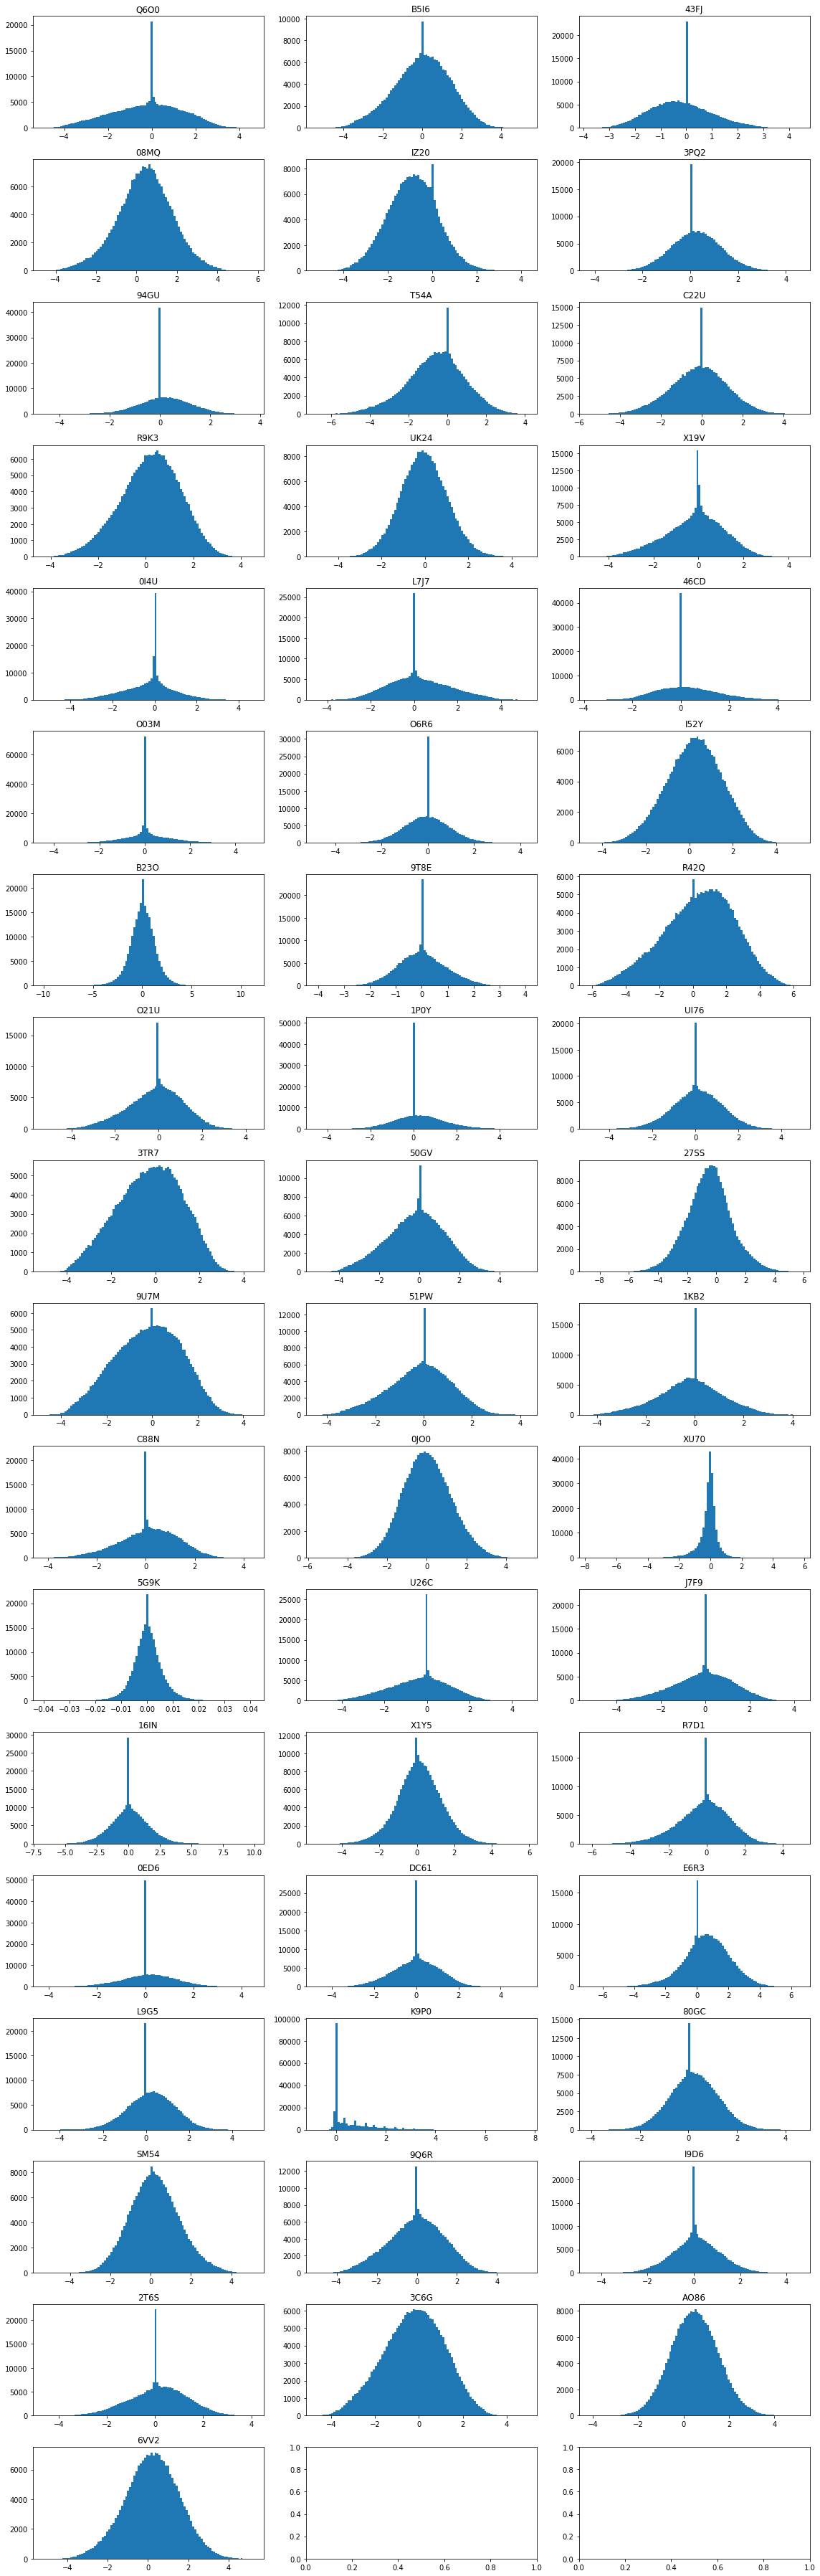

In [20]:
# create histograms for all unthresholded maps
for hyp in [1,2,5,6,7,8,9]:
    outfile = os.path.join(output_dir,'figures/hyp%d_unthresh_histogram.pdf'%hyp)
    if not os.path.exists(outfile):
        print('making figure for hyp',hyp)
        unthresh_data,labels=get_masked_data(hyp,mask_img,output_dir,imgtype='unthresh',dataset='rectified')
        fig, ax = plt.subplots(int(numpy.ceil(len(labels)/3)),3,figsize=(16,50))
        ctr_x=0
        ctr_y=0
        for i,l in enumerate(labels):
                ax[ctr_x,ctr_y].hist(unthresh_data[i,:],100)
                ax[ctr_x,ctr_y].set_title(l)
                ctr_y+=1
                if ctr_y>2:
                    ctr_y=0
                    ctr_x+=1
        plt.tight_layout()

        plt.savefig(outfile)


### convert all to Z stats


In [4]:

map_info = pandas.read_csv(os.path.join(basedir,'narps_neurovault_images_details.csv'))
map_info.head()
unthresh_stat_type=map_info[['teamID (the four-characters string identifying your analysis team)',
                             'Our unthresholded images on neurovault represent (if other, please specify)']]
unthresh_stat_type.columns=['teamID','imgtype']
unthresh_stat_type.index = unthresh_stat_type.teamID
unthresh_stat_type = unthresh_stat_type.drop_duplicates(subset='teamID',keep='last')
unthresh_stat_type.loc[:,'imgtype']= [i.split('values')[0].strip() for i in unthresh_stat_type.imgtype]

# manual fixes
unthresh_stat_type.loc['E3B6','imgtype']='t'
# for those that don't fit, set to NA
unthresh_stat_type.loc[:,'imgtype']=[i if i in ['t','z'] else 'NA' for i in unthresh_stat_type.imgtype ]

n_participants=metadata[['n_participants','NV_collection_string']]

n_participants.index = metadata.teamID

unthresh_stat_type = unthresh_stat_type.merge(n_participants,left_index=True,right_index=True)


In [16]:
zdir = os.path.join(output_dir,'zstats')
if not os.path.exists(zdir):
    os.mkdir(zdir)
    
for i,teamID in enumerate(unthresh_stat_type.index):
    n=unthresh_stat_type.loc[teamID,'n_participants']
    collection = unthresh_stat_type.loc[teamID,'NV_collection_string']
    for hyp in hypnums:
        infile = os.path.join(output_dir,'resampled/%s_%s/hypo%d_unthresh.nii.gz'%(collection,teamID,hyp))
        if not os.path.exists(infile):
            print('skipping',infile)
            continue
        outfile = os.path.join(output_dir,'zstats/%s_%s/hypo%d_unthresh.nii.gz'%(collection,teamID,hyp))
        if not os.path.exists(os.path.dirname(outfile)):
            os.mkdir(os.path.dirname(outfile))
            
        if unthresh_stat_type.loc[teamID,'imgtype'] == 't':
            print("converting %s (hyp %d) to z - %d participants"%(teamID,hyp,n))
            TtoZ(infile,outfile,n-1)
        elif unthresh_stat_type.loc[teamID,'imgtype'] == 'z':
            if not os.path.exists(outfile):
                print('copying',teamID)
                shutil.copy(infile,os.path.dirname(outfile))
        else:
            print('skipping %s - other data type'%teamID)

skipping /Users/poldrack/data_unsynced/NARPS/maps/resampled/OXLAIRNK_Q58J/hypo1_unthresh.nii.gz
skipping /Users/poldrack/data_unsynced/NARPS/maps/resampled/OXLAIRNK_Q58J/hypo2_unthresh.nii.gz
skipping /Users/poldrack/data_unsynced/NARPS/maps/resampled/OXLAIRNK_Q58J/hypo5_unthresh.nii.gz
skipping /Users/poldrack/data_unsynced/NARPS/maps/resampled/OXLAIRNK_Q58J/hypo6_unthresh.nii.gz
skipping /Users/poldrack/data_unsynced/NARPS/maps/resampled/OXLAIRNK_Q58J/hypo7_unthresh.nii.gz
skipping /Users/poldrack/data_unsynced/NARPS/maps/resampled/OXLAIRNK_Q58J/hypo8_unthresh.nii.gz
skipping /Users/poldrack/data_unsynced/NARPS/maps/resampled/OXLAIRNK_Q58J/hypo9_unthresh.nii.gz
converting Q6O0 (hyp 1) to z - 107 participants
converting Q6O0 (hyp 2) to z - 107 participants
converting Q6O0 (hyp 5) to z - 107 participants
converting Q6O0 (hyp 6) to z - 107 participants
converting Q6O0 (hyp 7) to z - 107 participants
converting Q6O0 (hyp 8) to z - 107 participants
converting Q6O0 (hyp 9) to z - 107 parti

### Estimate smoothness



In [23]:

est = SmoothEstimate()
smoothness = []
for hyp in hypnums:
    print('estimating smoothness for hyp',hyp)
    for i in input_dirs:
        resampdir = i.replace('orig','resampled')
        collectionID = os.path.basename(i)
        teamID = collectionID.split('_')[1]
        unthreshfile = os.path.join(resampdir,'hypo%d_unthresh.nii.gz'%hyp)    
        if not os.path.exists(unthreshfile):
            continue
        est.inputs.zstat_file = unthreshfile
        est.inputs.mask_file = mask_img
        smoothest_output = est.run()
        smoothness.append([teamID,hyp,smoothest_output.outputs.dlh,
                                       smoothest_output.outputs.volume,
                                       smoothest_output.outputs.resels])

        
smoothness_df = pandas.DataFrame(smoothness,columns=['teamID','hyp','dlh','volume','resels'])
smoothness_df.to_csv('smoothness_est.csv')

estimating smoothness for hyp 1
190612-18:47:02,587 nipype.interface INFO:
	 stdout 2019-06-12T18:47:02.587211:DLH 0.011885
190612-18:47:02,588 nipype.interface INFO:
	 stdout 2019-06-12T18:47:02.587211:VOLUME 228483
190612-18:47:02,589 nipype.interface INFO:
	 stdout 2019-06-12T18:47:02.587211:RESELS 388.444
190612-18:47:02,883 nipype.interface INFO:
	 stdout 2019-06-12T18:47:02.883431:DLH 0.038528
190612-18:47:02,885 nipype.interface INFO:
	 stdout 2019-06-12T18:47:02.883431:VOLUME 228483
190612-18:47:02,887 nipype.interface INFO:
	 stdout 2019-06-12T18:47:02.883431:RESELS 119.826
190612-18:47:03,117 nipype.interface INFO:
	 stdout 2019-06-12T18:47:03.116973:DLH 0.0305252
190612-18:47:03,119 nipype.interface INFO:
	 stdout 2019-06-12T18:47:03.116973:VOLUME 228483
190612-18:47:03,120 nipype.interface INFO:
	 stdout 2019-06-12T18:47:03.116973:RESELS 151.241
190612-18:47:03,373 nipype.interface INFO:
	 stdout 2019-06-12T18:47:03.373817:DLH 0.0163199
190612-18:47:03,377 nipype.interface 

In [26]:
smoothness_df.sort_values(by='dlh').query('hyp==1')

,teamID,hyp,dlh,volume,resels
4,IZ20,1,0.004174,228483,1106.07000
24,3TR7,1,0.006984,228483,661.04600
48,2T6S,1,0.011020,228483,418.92200
35,J7F9,1,0.011117,228483,415.28600
27,9U7M,1,0.011432,228483,403.85300
0,Q6O0,1,0.011885,228483,388.44400
49,3C6G,1,0.012719,228483,362.97400
3,08MQ,1,0.016320,228483,282.88600
29,1KB2,1,0.016583,228483,278.39200
20,R42Q,1,0.017894,228483,257.99800


In [24]:
smoothest_output.outputs


dlh = 0.011885
resels = 388.444
volume = 228483